In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, scale
import xgboost as xgb
from sklearn.metrics import mean_squared_error, auc, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split

In [3]:
# load the dataset
train = pd.read_csv('train.csv')

# create labelencoder
le = LabelEncoder()

train = train.drop(['Name', 'Cabin'], axis=1).fillna(train['Age'].mean())
cat_columns = train.select_dtypes('object').columns
train[cat_columns] = train[cat_columns].apply(lambda col: le.fit_transform(col.astype(str)))
train.describe()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
count,623.000000,623.000000,623.000000,623.000000,623.000000,623.000000,623.000000,623.000000,623.000000,623.000000
mean,452.372392,0.394864,2.295345,0.632424,29.685453,0.536116,0.398074,253.264848,33.810232,2.494382
std,251.236932,0.489214,0.846457,0.482533,13.031650,1.085521,0.826877,148.563406,51.205014,0.823422
min,1.000000,0.000000,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,242.500000,0.000000,1.000000,0.000000,22.000000,0.000000,0.000000,122.500000,7.925000,2.000000
50%,448.000000,0.000000,3.000000,1.000000,29.685453,0.000000,0.000000,253.000000,14.500000,3.000000
75%,665.000000,1.000000,3.000000,1.000000,35.000000,1.000000,0.000000,386.500000,33.760400,3.000000
max,891.000000,1.000000,3.000000,1.000000,80.000000,8.000000,6.000000,503.000000,512.329200,3.000000


In [4]:
# separate X and Y
X = train.drop(['PassengerId', 'Ticket', 'Survived'], axis=1)
y = train[['Survived']]

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1, random_state=42)

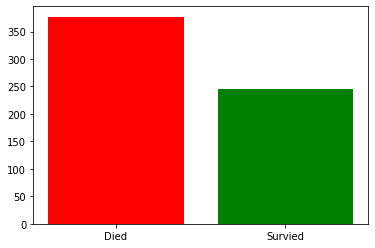

In [6]:
plt.bar(x=[0, 1], height=y.groupby('Survived').size(), color=['red', 'green'])
plt.xticks([0, 1], ['Died', 'Survied']);

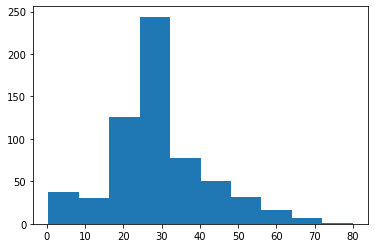

In [8]:
plt.hist(X['Age']);

In [7]:
# convert to DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [8]:
# params to tune
params = {
    'max_depth': 6,
    'min_child_weight': 1,
    'eta': .3,
    'subsample': 1,
    'colsample_bytree': 1,
    # Other parameters
    'objective':'binary:logistic',
}

params['eval_metric'] = 'auc'

num_boost_round = 999

In [9]:
model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, 'Test')],
    early_stopping_rounds=10
)

[0]	Test-auc:0.83105
Will train until Test-auc hasn't improved in 10 rounds.
[1]	Test-auc:0.84789
[2]	Test-auc:0.85211
[3]	Test-auc:0.84895
[4]	Test-auc:0.87316
[5]	Test-auc:0.86895
[6]	Test-auc:0.87684
[7]	Test-auc:0.87895
[8]	Test-auc:0.88000
[9]	Test-auc:0.87263
[10]	Test-auc:0.88211
[11]	Test-auc:0.88211
[12]	Test-auc:0.88842
[13]	Test-auc:0.88842
[14]	Test-auc:0.89053
[15]	Test-auc:0.88947
[16]	Test-auc:0.88632
[17]	Test-auc:0.88632
[18]	Test-auc:0.89053
[19]	Test-auc:0.87947
[20]	Test-auc:0.87526
[21]	Test-auc:0.87211
[22]	Test-auc:0.87211
[23]	Test-auc:0.87316
[24]	Test-auc:0.87947
Stopping. Best iteration:
[14]	Test-auc:0.89053



In [10]:
cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    seed=42,
    nfold=5,
    metrics={'auc'},
    early_stopping_rounds=10
)

cv_results

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.899551,0.003993,0.865843,0.014741
1,0.912553,0.007032,0.866968,0.012215


In [11]:
cv_results['test-auc-mean'].max()

0.866968

In [12]:
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(1, 10)
    for min_child_weight in range(1, 10)
]

In [13]:
# Define initial best params
max_auc = float(0)
best_params = None

for max_depth, min_child_weight in gridsearch_params:
    print(f'CV with max_depth = {max_depth}, min_child_weight = {min_child_weight}')   # Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight 
          
    # run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'auc'},
        early_stopping_rounds=10
    )
          
    # update best AUC model    
    mean_auc = cv_results['test-auc-mean'].max()
    boost_rounds = cv_results['test-auc-mean'].argmax()
    print(f'\tAUC {mean_auc} for {boost_rounds} rounds')
    if mean_auc > max_auc:
        max_auc = mean_auc
        best_params = (max_depth, min_child_weight)
        print(f'Best params: {best_params[0]}, {best_params[1]}, AUC: {max_auc}')

print('\nBest params:', best_params)

CV with max_depth = 1, min_child_weight = 1
	AUC 0.8427228 for 24 rounds
Best params: 1, 1, AUC: 0.8427228
CV with max_depth = 1, min_child_weight = 2
	AUC 0.8426042 for 24 rounds
CV with max_depth = 1, min_child_weight = 3
	AUC 0.8435902000000001 for 24 rounds
Best params: 1, 3, AUC: 0.8435902000000001
CV with max_depth = 1, min_child_weight = 4
	AUC 0.8449458 for 29 rounds
Best params: 1, 4, AUC: 0.8449458
CV with max_depth = 1, min_child_weight = 5
	AUC 0.8416876 for 27 rounds
CV with max_depth = 1, min_child_weight = 6
	AUC 0.8393727999999999 for 37 rounds
CV with max_depth = 1, min_child_weight = 7
	AUC 0.8346351999999999 for 27 rounds
CV with max_depth = 1, min_child_weight = 8
	AUC 0.8349914 for 23 rounds
CV with max_depth = 1, min_child_weight = 9
	AUC 0.8348368 for 26 rounds
CV with max_depth = 2, min_child_weight = 1
	AUC 0.8669068 for 20 rounds
Best params: 2, 1, AUC: 0.8669068
CV with max_depth = 2, min_child_weight = 2
	AUC 0.8660584 for 24 rounds
CV with max_depth = 2, mi

In [14]:
params['max_depth'], params['min_child_weight'] = best_params
params

{'max_depth': 6,
 'min_child_weight': 2,
 'eta': 0.3,
 'subsample': 1,
 'colsample_bytree': 1,
 'objective': 'binary:logistic',
 'eval_metric': 'auc'}

In [15]:
model2 = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, 'Test')],
    early_stopping_rounds=10
)

[0]	Test-auc:0.82790
Will train until Test-auc hasn't improved in 10 rounds.
[1]	Test-auc:0.83684
[2]	Test-auc:0.87526
[3]	Test-auc:0.87368
[4]	Test-auc:0.87789
[5]	Test-auc:0.88842
[6]	Test-auc:0.88211
[7]	Test-auc:0.88737
[8]	Test-auc:0.88316
[9]	Test-auc:0.88737
[10]	Test-auc:0.89053
[11]	Test-auc:0.88737
[12]	Test-auc:0.89158
[13]	Test-auc:0.88211
[14]	Test-auc:0.88947
[15]	Test-auc:0.89053
[16]	Test-auc:0.88947
[17]	Test-auc:0.89158
[18]	Test-auc:0.88158
[19]	Test-auc:0.88263
[20]	Test-auc:0.88053
[21]	Test-auc:0.88158
[22]	Test-auc:0.88579
Stopping. Best iteration:
[12]	Test-auc:0.89158



In [16]:
gridsearch_params = [
    (subsample, colsample)
    for subsample in [0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
    for colsample in [0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
]

In [17]:
# Define initial best params
max_auc = float(0)
best_params = None

# start reversed (max -> min)
for subsample, colsample in reversed(gridsearch_params):
    print(f'CV with subsample = {subsample}, colsample = {colsample}')   # Update our parameters
    params['subsample'] = subsample
    params['colsample_bytree'] = colsample 
          
    # run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'auc'},
        early_stopping_rounds=10
    )
          
    # update best AUC model    
    mean_auc = cv_results['test-auc-mean'].max()
    boost_rounds = cv_results['test-auc-mean'].argmax()
    print(f'\tAUC {mean_auc} for {boost_rounds} rounds')
    if mean_auc > max_auc:
        max_auc = mean_auc
        best_params = (subsample, colsample)
        print(f'Best params: {best_params[0]}, {best_params[1]}, AUC: {max_auc}')

print('\nBest params:', best_params)

CV with subsample = 1, colsample = 1
	AUC 0.8755496 for 5 rounds
Best params: 1, 1, AUC: 0.8755496
CV with subsample = 1, colsample = 0.9
	AUC 0.8726557999999999 for 0 rounds
CV with subsample = 1, colsample = 0.8
	AUC 0.8720274 for 0 rounds
CV with subsample = 1, colsample = 0.7
	AUC 0.8669546 for 8 rounds
CV with subsample = 1, colsample = 0.6
	AUC 0.8669546 for 8 rounds
CV with subsample = 1, colsample = 0.5
	AUC 0.8632564 for 10 rounds
CV with subsample = 1, colsample = 0.4
	AUC 0.8568072000000001 for 23 rounds
CV with subsample = 1, colsample = 0.3
	AUC 0.8568072000000001 for 23 rounds
CV with subsample = 1, colsample = 0.2
	AUC 0.8427622000000001 for 23 rounds
CV with subsample = 1, colsample = 0.15
	AUC 0.8427622000000001 for 23 rounds
CV with subsample = 1, colsample = 0.1
	AUC 0.8427622000000001 for 23 rounds
CV with subsample = 1, colsample = 0.05
	AUC 0.8427622000000001 for 23 rounds
CV with subsample = 0.9, colsample = 1
	AUC 0.8662614 for 5 rounds
CV with subsample = 0.9, 

	AUC 0.8339702000000001 for 9 rounds
CV with subsample = 0.15, colsample = 0.7
	AUC 0.8329686000000001 for 9 rounds
CV with subsample = 0.15, colsample = 0.6
	AUC 0.8329686000000001 for 9 rounds
CV with subsample = 0.15, colsample = 0.5
	AUC 0.8282265999999998 for 7 rounds
CV with subsample = 0.15, colsample = 0.4
	AUC 0.8182674000000001 for 2 rounds
CV with subsample = 0.15, colsample = 0.3
	AUC 0.8182674000000001 for 2 rounds
CV with subsample = 0.15, colsample = 0.2
	AUC 0.80288 for 7 rounds
CV with subsample = 0.15, colsample = 0.15
	AUC 0.80288 for 7 rounds
CV with subsample = 0.15, colsample = 0.1
	AUC 0.80288 for 7 rounds
CV with subsample = 0.15, colsample = 0.05
	AUC 0.80288 for 7 rounds
CV with subsample = 0.1, colsample = 1
	AUC 0.8419222 for 9 rounds
CV with subsample = 0.1, colsample = 0.9
	AUC 0.8311098000000001 for 7 rounds
CV with subsample = 0.1, colsample = 0.8
	AUC 0.8262039999999999 for 4 rounds
CV with subsample = 0.1, colsample = 0.7
	AUC 0.8261263999999999 for 11

In [18]:
params['subsample'], params['colsample_bytree'] = best_params
params

{'max_depth': 6,
 'min_child_weight': 2,
 'eta': 0.3,
 'subsample': 1,
 'colsample_bytree': 1,
 'objective': 'binary:logistic',
 'eval_metric': 'auc'}

In [19]:
model3 = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, 'Test')],
    early_stopping_rounds=10
)

[0]	Test-auc:0.82790
Will train until Test-auc hasn't improved in 10 rounds.
[1]	Test-auc:0.83684
[2]	Test-auc:0.87526
[3]	Test-auc:0.87368
[4]	Test-auc:0.87789
[5]	Test-auc:0.88842
[6]	Test-auc:0.88211
[7]	Test-auc:0.88737
[8]	Test-auc:0.88316
[9]	Test-auc:0.88737
[10]	Test-auc:0.89053
[11]	Test-auc:0.88737
[12]	Test-auc:0.89158
[13]	Test-auc:0.88211
[14]	Test-auc:0.88947
[15]	Test-auc:0.89053
[16]	Test-auc:0.88947
[17]	Test-auc:0.89158
[18]	Test-auc:0.88158
[19]	Test-auc:0.88263
[20]	Test-auc:0.88053
[21]	Test-auc:0.88158
[22]	Test-auc:0.88579
Stopping. Best iteration:
[12]	Test-auc:0.89158



In [20]:
max_auc = float(0)
best_params = None

# start reversed (max -> min)
for eta in [.31, .309, .308, .307, .306, .305, .304, .303, .302, .301, .3, .299]:
    print(f'CV with eta = {eta}')   # Update our parameters
    params['eta'] = eta
          
    # run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'auc'},
        early_stopping_rounds=10
    )
          
    # update best AUC model    
    mean_auc = cv_results['test-auc-mean'].max()
    boost_rounds = cv_results['test-auc-mean'].argmax()
    print(f'\tAUC {mean_auc} for {boost_rounds} rounds')
    if mean_auc > max_auc:
        max_auc = mean_auc
        best_params = (eta)
        print(f'Best params: {best_params}, AUC: {max_auc}')

print('\nBest params:', best_params)

CV with eta = 0.31
	AUC 0.8717969999999999 for 7 rounds
Best params: 0.31, AUC: 0.8717969999999999
CV with eta = 0.309
	AUC 0.871368 for 7 rounds
CV with eta = 0.308
	AUC 0.8730924000000002 for 5 rounds
Best params: 0.308, AUC: 0.8730924000000002
CV with eta = 0.307
	AUC 0.8728543999999999 for 5 rounds
CV with eta = 0.306
	AUC 0.8733306000000001 for 5 rounds
Best params: 0.306, AUC: 0.8733306000000001
CV with eta = 0.305
	AUC 0.8733306000000001 for 5 rounds
CV with eta = 0.304
	AUC 0.8733306000000001 for 5 rounds
CV with eta = 0.303
	AUC 0.8759176 for 5 rounds
Best params: 0.303, AUC: 0.8759176
CV with eta = 0.302
	AUC 0.8758144000000001 for 5 rounds
CV with eta = 0.301
	AUC 0.8755838 for 5 rounds
CV with eta = 0.3
	AUC 0.8755496 for 5 rounds
CV with eta = 0.299
	AUC 0.8724102 for 5 rounds

Best params: 0.303


In [21]:
params['eta'] = best_params
params

{'max_depth': 6,
 'min_child_weight': 2,
 'eta': 0.303,
 'subsample': 1,
 'colsample_bytree': 1,
 'objective': 'binary:logistic',
 'eval_metric': 'auc'}

In [22]:
model4 = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, 'Test')],
    early_stopping_rounds=10
)

[0]	Test-auc:0.82790
Will train until Test-auc hasn't improved in 10 rounds.
[1]	Test-auc:0.83684
[2]	Test-auc:0.87526
[3]	Test-auc:0.87368
[4]	Test-auc:0.87789
[5]	Test-auc:0.88842
[6]	Test-auc:0.88474
[7]	Test-auc:0.88526
[8]	Test-auc:0.88526
[9]	Test-auc:0.88211
[10]	Test-auc:0.88000
[11]	Test-auc:0.87895
[12]	Test-auc:0.86842
[13]	Test-auc:0.87105
[14]	Test-auc:0.86895
[15]	Test-auc:0.86684
Stopping. Best iteration:
[5]	Test-auc:0.88842



In [36]:
num_boost_round = model4.best_iteration + 1

best_model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, 'Test')]
)

[0]	Test-auc:0.82790
[1]	Test-auc:0.83684
[2]	Test-auc:0.87526
[3]	Test-auc:0.87368
[4]	Test-auc:0.87789
[5]	Test-auc:0.88842


In [89]:
# predict
y_pred = best_model.predict(dtest)
y_pred = y_pred.reshape((y_pred.shape[0], 1))

auc = roc_auc_score(y_test, y_pred)
auc

0.888421052631579

In [43]:
params

{'max_depth': 6,
 'min_child_weight': 2,
 'eta': 0.303,
 'subsample': 1,
 'colsample_bytree': 1,
 'objective': 'binary:logistic',
 'eval_metric': 'auc'}

In [47]:
# load test for submission
test = pd.read_csv('test.csv')

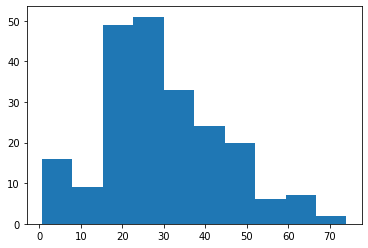

In [48]:
plt.hist(test['Age']);

In [49]:
# id
id_passenger = test[['PassengerId']]

# use only train features
test = test[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']]
test['Age'] = test['Age'].fillna(test['Age'].mean())

cat_columns = test.select_dtypes('object').columns
test[cat_columns] = test[cat_columns].apply(lambda col: LabelEncoder().fit_transform(col.astype(str)))
test

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,1,20.000000,0,0,7.0500,2
1,3,0,18.000000,2,0,18.0000,2
2,2,1,0.670000,1,1,14.5000,2
3,1,1,58.000000,0,2,113.2750,0
4,3,1,30.000000,0,0,7.2292,0
...,...,...,...,...,...,...,...
263,3,1,29.730415,0,0,7.7500,1
264,3,1,41.000000,0,0,7.1250,2
265,2,0,34.000000,0,1,23.0000,2
266,3,0,4.000000,0,2,22.0250,2


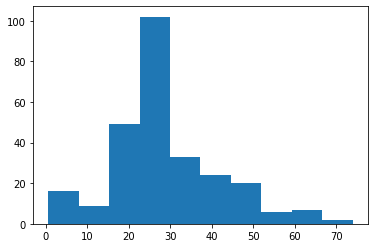

In [50]:
plt.hist(test['Age']);

In [54]:
# generate predictions from submit data
dtest_submit = xgb.DMatrix(test)
pred_submit = best_model.predict(dtest_submit)

df_submit = pd.concat([id_passenger, pd.DataFrame(pred_submit, columns=['Survived'])], axis=1)
df_submit

,PassengerId,Survived
0,132,0.131064
1,39,0.828358
2,756,0.781268
3,660,0.242448
4,799,0.151093
...,...,...
263,197,0.151093
264,762,0.135955
265,99,0.882265
266,185,0.238369


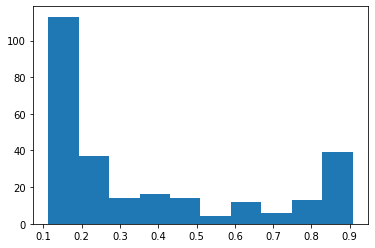

In [67]:
plt.hist(df_submit['Survived']);

In [55]:
df_submit.to_csv(f'auc{auc}.csv', index=False)